In [5]:
import os
import importlib
import sys
import pandas as pd 
sys.path.append(r"C:\Users\Artem\Desktop\vs code project\SARIMA_for_git\src")
importlib.reload(importlib.import_module('utils'))
import utils as utils

In [12]:
path2 = 'C:\\Users\\Artem\\Desktop\\vs code project\\SARIMA_for_git\\energy_dataset.csv'
csv2 = pd.read_csv(path2)
df_energy = pd.DataFrame(csv2)
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)
df = df_energy.set_index("time")[["total load actual"]].copy()
df = df[-(30*24 + 365*2*24):]

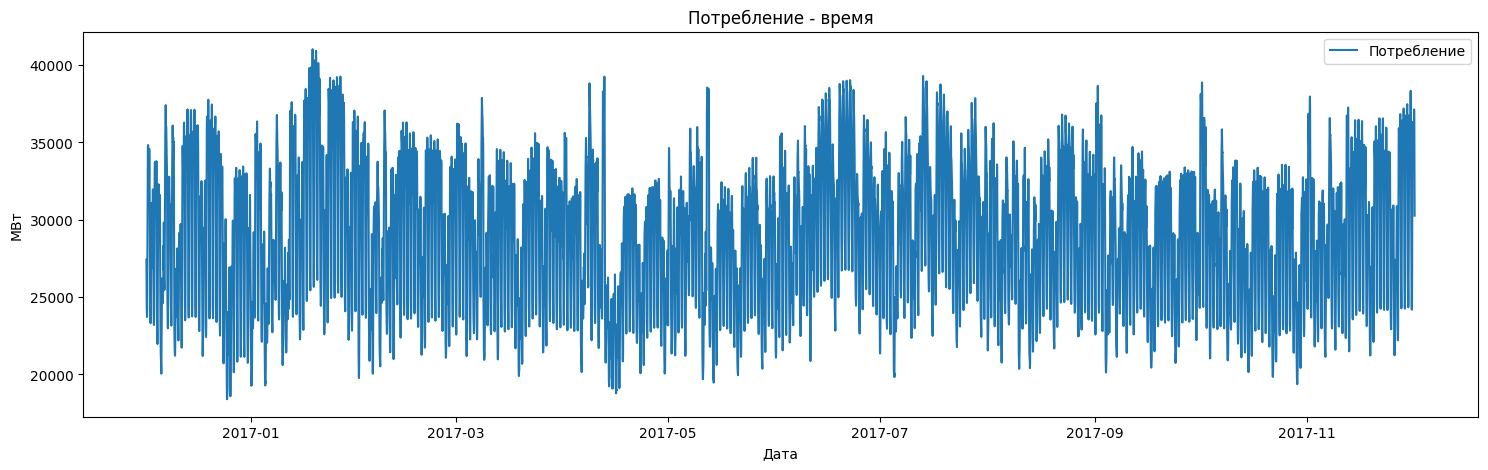

In [16]:
utils.visual(df.interpolate(), start_points = 0, end_points=24*365)

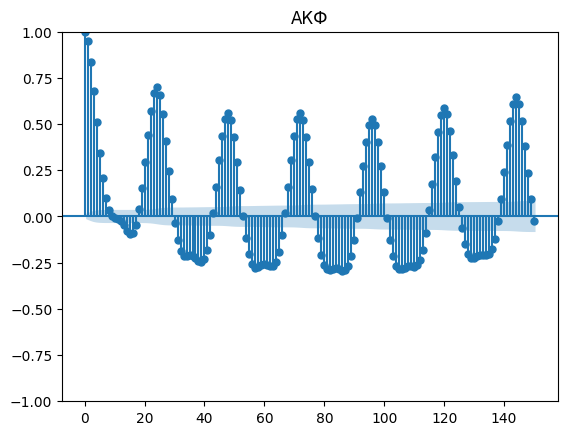

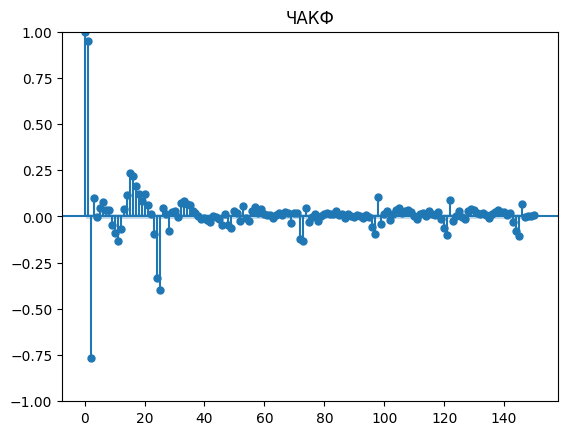

In [17]:
utils.corralelogramm(df, lags_acf=150, lags_pacf=150)

In [102]:
utils.static_tests(df)

ADF Statistic: -21.420315756960584
p-value: 0.0
Critical Value (1%): -3.431
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Результат: p-value <= 0.05 -> Отвергаем H0. Ряд СТАЦИОНАРЕН.

KPSS Statistic: 0.8696600412327765
p-value: 0.01
Number of Lags: 70
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739
Результат: p-value < 0.05 -> Отвергаем H0. Ряд НЕ стационарен.


c:\Users\Artem\Desktop\vs code project\SARIMA_for_git\src\utils.py:101: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, n_lags, critical_values = kpss(df.interpolate(), regression=regression)


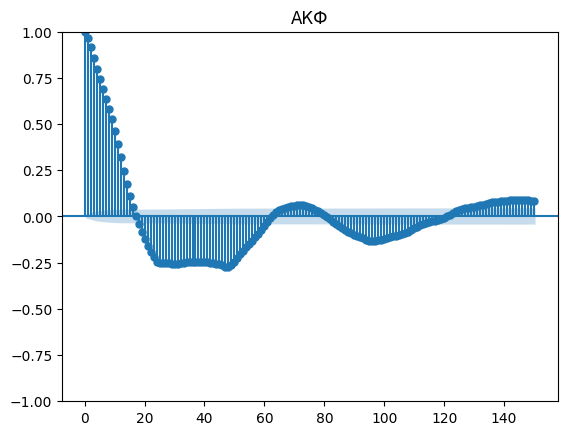

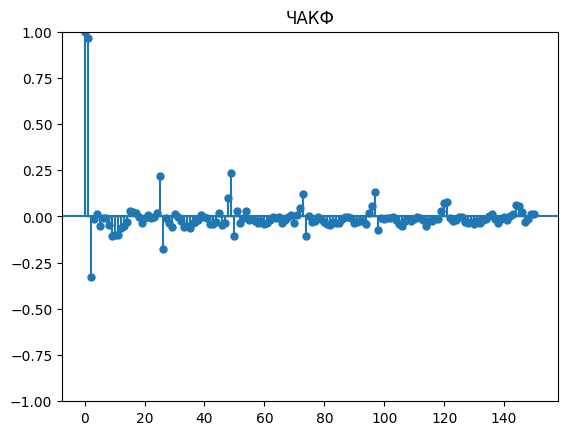

In [104]:
diff_df = utils.diff(df, lag=24)
utils.corralelogramm(diff_df, lags_acf=150, lags_pacf=150)

In [105]:
utils.static_tests(diff_df)

ADF Statistic: -28.705147895398305
p-value: 0.0
Critical Value (1%): -3.431
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Результат: p-value <= 0.05 -> Отвергаем H0. Ряд СТАЦИОНАРЕН.

KPSS Statistic: 0.0026682736573487497
p-value: 0.1
Number of Lags: 102
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739
Результат: p-value >= 0.05 -> Не можем отвергнуть H0. Ряд стационарен.


c:\Users\Artem\Desktop\vs code project\SARIMA_for_git\src\utils.py:101: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, n_lags, critical_values = kpss(df.interpolate(), regression=regression)


In [18]:
df_fourier = utils.create_exog_fourier(df)
df_fourier.head(3)

,const,"sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)",...,"sin(4,freq=W-SUN)","cos(4,freq=W-SUN)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
time,,,,,,,,,,,,,,,,,,,,,
2016-12-01 23:00:00,1.0,-0.258819,0.965926,-0.5,0.866025,-0.399892,-0.916562,0.733052,0.680173,-0.943883,...,0.997204,-0.074730,0.193019,0.981195,0.378779,0.925487,0.550293,0.834972,0.701110,0.713053
2016-12-02 00:00:00,1.0,0.000000,1.000000,0.0,1.000000,-0.433884,-0.900969,0.781831,0.623490,-0.974928,...,0.974928,-0.222521,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2016-12-02 01:00:00,1.0,0.258819,0.965926,0.5,0.866025,-0.467269,-0.884115,0.826239,0.563320,-0.993712,...,0.930874,-0.365341,0.209564,0.977795,0.409820,0.912166,0.591877,0.806028,0.747649,0.664095


In [19]:
df_features = utils.create_exog_calendar(df)
df_features.head(3)

,is_weekend,month,is_night,is_evening
time,,,,
2016-12-01 23:00:00,0,12,0,1
2016-12-02 00:00:00,0,12,0,1
2016-12-02 01:00:00,0,12,0,0


In [20]:
exog = utils.concat_and_create_exog_fourier_for_weekend(df_fourier, df_features)
exog

,const,"sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)",...,is_evening,hour,"sin(1,freq=W-SUN)_wkend","cos(1,freq=W-SUN)_wkend","sin(2,freq=W-SUN)_wkend","cos(2,freq=W-SUN)_wkend","sin(3,freq=W-SUN)_wkend","cos(3,freq=W-SUN)_wkend","sin(4,freq=W-SUN)_wkend","cos(4,freq=W-SUN)_wkend"
time,,,,,,,,,,,,,,,,,,,,,
2016-12-01 23:00:00,1.0,-0.258819,9.659258e-01,-5.000000e-01,8.660254e-01,-0.399892,-0.916562,0.733052,6.801727e-01,-0.943883,...,1,23,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
2016-12-02 00:00:00,1.0,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,-0.433884,-0.900969,0.781831,6.234898e-01,-0.974928,...,1,0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
2016-12-02 01:00:00,1.0,0.258819,9.659258e-01,5.000000e-01,8.660254e-01,-0.467269,-0.884115,0.826239,5.633201e-01,-0.993712,...,0,1,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
2016-12-02 02:00:00,1.0,0.500000,8.660254e-01,8.660254e-01,5.000000e-01,-0.500000,-0.866025,0.866025,5.000000e-01,-1.000000,...,0,2,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
2016-12-02 03:00:00,1.0,0.707107,7.071068e-01,1.000000e+00,6.123234e-17,-0.532032,-0.846724,0.900969,4.338837e-01,-0.993712,...,0,3,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,1.0,-1.000000,-1.836970e-16,3.673940e-16,-1.000000e+00,0.623490,0.781831,0.974928,2.225209e-01,0.900969,...,0,18,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0
2018-12-31 19:00:00,1.0,-0.965926,2.588190e-01,-5.000000e-01,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01,0.846724,...,0,19,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0
2018-12-31 20:00:00,1.0,-0.866025,5.000000e-01,-8.660254e-01,-5.000000e-01,0.680173,0.733052,0.997204,7.473009e-02,0.781831,...,1,20,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0


In [21]:
train, test, exog_train, exog_test  = utils.train_test_split_with_exog(df, exog)
len(train), len(test), len(exog_train), len(exog_test)

(14592, 3648, 14592, 3648)

In [22]:
ex_tr_s, ex_test_s = utils.exog_scaler(exog_train, exog_test)
ex_tr_s.head(3)

,const,"sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)",...,is_evening,hour,"sin(1,freq=W-SUN)_wkend","cos(1,freq=W-SUN)_wkend","sin(2,freq=W-SUN)_wkend","cos(2,freq=W-SUN)_wkend","sin(3,freq=W-SUN)_wkend","cos(3,freq=W-SUN)_wkend","sin(4,freq=W-SUN)_wkend","cos(4,freq=W-SUN)_wkend"
time,,,,,,,,,,,,,,,,,,,,,
2016-12-01 23:00:00,0.0,-3.660254e-01,1.366025,-7.071068e-01,1.224745,-0.565005,-1.299389,1.036014,0.964346,-1.334403,...,1.949359,1.661325,0.561425,-0.480032,0.462181,0.101718,0.044488,0.119817,0.047112,-0.077402
2016-12-02 00:00:00,0.0,-2.349974e-17,1.414214,-9.038361e-19,1.414214,-0.613042,-1.277321,1.104968,0.884149,-1.378301,...,1.949359,-1.661325,0.561425,-0.480032,0.462181,0.101718,0.044488,0.119817,0.047112,-0.077402
2016-12-02 01:00:00,0.0,3.660254e-01,1.366025,7.071068e-01,1.224745,-0.660222,-1.253469,1.167742,0.799019,-1.404863,...,-0.512989,-1.516862,0.561425,-0.480032,0.462181,0.101718,0.044488,0.119817,0.047112,-0.077402


In [23]:
utils.save_data(train, test, ex_tr_s, ex_test_s)

Данные сохранены в папку ../data
